# Permutation Importance Benchmarking

Comparing stability and runtime between oob permutation importance and `sklearn.inspection.permutation_importance`


## Stability

Which method produces more consistent values on the same data?

To make an accurate comparison, I want to compare the time, stability, and values between the currently implemented `permutation_importance` in the `inspection` module and oob permutation importance. 

Feature importances will be calculated using the training data. Oob importances will be calculated on an estimator fit on the entire training set, while `inspection.permutation_importance` will be calculated on a validation set held out from within the training set.

In [32]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification, make_regression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

In [33]:
# Create classification dataset
X, y = make_classification(n_samples=500, n_features=10, n_informative=3, 
                                       n_redundant=0, n_repeated=0, shuffle=False, flip_y=0.2)

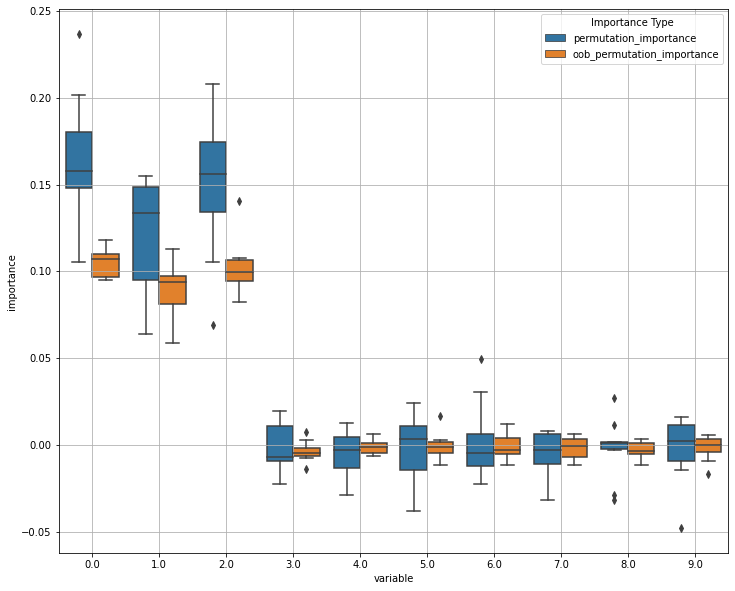

In [35]:
# Compare feature importances across ten iterations
def plot_importances(est, val_size: float=0.25, it: int=10):
    """Plot multiple rounds of feature importances of three methods on 
    the same training data. The three methods are:

    - oob_permutation_importance - permutation importance calculated on the
        oob data in the Random Forest
    - permutation_importance - using `sklearn.inspection.permutation_importance`
    - impurity - default feature importances

    Parameters
    ----------
    est : RandomForestClassifier or RandomForestRegressor
        [description]
    val_size : float, optional
        Proportion of training data to use for sklearn.inspection.permutation_importance, by default 0.25
    it : int, optional
        Number of times to refit and recalculate feature importances, by default 10
    """
    imp_df_list = []
    for imp_type in ['permutation_importance', 'oob_permutation_importance']:
        importances = np.zeros((it * X.shape[1], 2))
        for i in range(it):
            curr_ind = np.arange(i * X.shape[1], (i + 1) * X.shape[1])
            importances[curr_ind, 0] = np.arange(len(curr_ind))
            if imp_type in ['oob_permutation_importance', 'impurity']:
                X_train = X.copy()
                y_train = y.copy()
                if imp_type == 'oob_permutation_importance':
                    use_imp = 'permutation'
                else:
                    use_imp = 'impurity'
            else:
                X_train, X_test, y_train, y_test = \
                    train_test_split(X, y, test_size=val_size, random_state=i)
                use_imp = 'impurity'
            est.set_params(importance_type=use_imp, random_state=i)
            est.fit(X_train, y_train)
            if imp_type in ['oob_permutation_importance', 'impurity']:
                importances[curr_ind, 1] = est.feature_importances_
            else:
                importances[curr_ind, 1] = permutation_importance(est, X_test, y_test, n_repeats=5, n_jobs=-1, random_state=i)["importances_mean"]
        curr_imp_df = pd.DataFrame(importances, columns=['variable', 'importance'])
        curr_imp_df['Importance Type'] = imp_type
        imp_df_list.append(curr_imp_df)
    imp_df = pd.concat(imp_df_list)
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.boxplot(data=imp_df, x='variable', y='importance', ax=ax, hue='Importance Type')
    ax.grid()
    plt.show()
    return imp_df
imp = plot_importances(RandomForestClassifier(n_estimators=10, random_state=0))

In [36]:
# Create regression dataset
X_train, y_train = make_regression(n_samples=500, n_features=10, n_informative=3, shuffle=False)

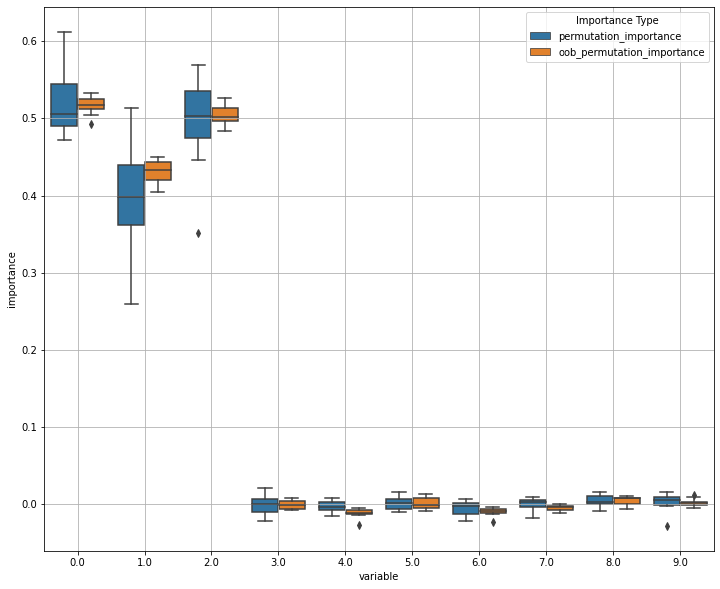

In [37]:
imp = plot_importances(RandomForestRegressor())

The OOB permutation importances are more stable across runs. Of course, this is sensitive to all kinds of things, especially sample size. The smaller the sample size, the more unstable `inspection.permutation_importance` will be.

## Time benchmarking

Comparing time to calculate feature importance

In [38]:
# Create dataset with first three features informative
X, y = make_classification(n_samples=1000, n_features=50, n_informative=3, n_redundant=2, shuffle=False, flip_y=0.3)

In [39]:
%%timeit
# OOB permutation importance
rf = RandomForestClassifier(n_jobs=-1, random_state=42, importance_type='permutation')
rf.fit(X, y)

893 ms ± 58.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
%%timeit
# inspection.permutation_importance
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
X_train, X_test, y_train, y_test = \
                    train_test_split(X, y, test_size=0.25, random_state=42)
rf.fit(X_train, y_train)
perm_imp = permutation_importance(rf, X_test, y_test, random_state=42)


6.42 s ± 411 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
%%timeit
# Default Feature importance
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
rf.fit(X, y)

298 ms ± 16.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


OOB permutation importance is faster than the `inspection` version in this specific example.

These examples obviously don't prove that oob is always faster or more stable, but are just meant to represent a general trend I've seen using both, and provide a reason why it would be worthwhile to have oob permutation importance.